We consider temperature control of a 2-dimensional domain $\Omega = [0, 1] \times [0, 1] \subseteq \mathbb{R}^2$. This control problem can be formulated as follows:
$$
    \begin{align*}
        \mathrm{minimize}_{x, u} \quad & \int_{0}^{T} \int_{\omega \in \Omega} \frac{1}{2} Q \left( x(\omega, t) - d(\omega, t) \right)^2 + \frac{1}{2} \, R \, u(\omega, t)^2 d\omega \, dt \\
        \mathrm{subject \; to} \quad & \frac{\rho C_p}{\kappa} \frac{\partial x(\omega, t)}{\partial t} =  \nabla^2 x - \frac{2 h_c}{\kappa t_z} \left( x(\omega, t) - \bar{T} \right) \\ & \quad - \frac{2 \epsilon \sigma}{\kappa t_z} \left( x(\omega, t)^4 - \bar{T}^4 \right) - \frac{1}{\kappa t_z} u(\omega, t) \quad \forall \, \omega \in \Omega \setminus \partial \Omega, \; t \in [0, T] \\
        & x(\omega, t) = \bar{T} \quad \forall \, \omega \in \partial \Omega, t \in [0, T] \\
        & x(\omega, 0) = x_0 \quad \forall \, \omega \in \Omega \setminus \partial \Omega \\
    \end{align*}
$$
where $x$ is the temperature, $u$ denotes the control input, $d \Omega$ is the boundary of the domain, and the desired temperature of the plate is represented by $d$. Problem parameters are as defined below.
 
We consider a discretized version of the above problem where the domain $\Omega$ is discretized using a uniform mesh consisting of elements with length $dx$. Similarly, we discretize the time horizon of 24 hours with elements of length $dt$ seconds:
$$
    \begin{alignat*}{1}
        \mathrm{minimize}_{x, u} \quad & \sum\limits_{t = 0}^{N} \sum\limits_{\ell = 0}^{L} \sum\limits_{w = 0}^{W} \frac{1}{2} Q(\ell, w) (x(t, \ell, w) - d(t, \ell, w))^2 + \frac{1}{2} R(\ell, w) \, u(t, \ell, w)^2 \\
        \mathrm{subject \; to} \quad & \frac{\rho C_p}{\kappa} \frac{x(t+1, \ell, w) - x(t, \ell, w)}{dt} = \\ & \qquad 1/dx^2 ( x(t, \ell+1, w) + x(t, \ell-1, w) + x(t, \ell, w-1) + \\ & \qquad  x(t, \ell, w+1) - 4x(t, \ell, w) )  - \frac{2 h_c}{\kappa t_z} \left( x(t, \ell, w) - \bar{T} \right) - \\ & \qquad \frac{2 \epsilon \sigma}{\kappa t_z} \left( x(t, \ell, w)^4 - \bar{T}^4 \right) - \frac{1}{\kappa t_z} u(t, \ell, w) \\ & \qquad \quad \forall \, \ell = [1, L-1], w = [1, W-1], t \in [1, N-1] \\
        & x(t, \ell, w) = \bar{T} \quad \forall \, \ell = \{0, L\}, w = \{0, W\}, t \in [0, N] \\
        & x(0, \ell, w) = x_0 \quad \forall \, \ell = [1, L-1], w = [1, W-1]
    \end{alignat*}
$$
We apply ADMM by temporally decomposing the temperature control problem. Since our ADMM scheme requires linear linking constraints, we introduce auxiliary variables $\tilde{x}$ as follows:
\begin{equation*}
x(t+1, \ell, w) = \tilde{x}(t, \ell, w)
\end{equation*}


In [1]:
using BlockNLPModels
using BlockNLPAlgorithms
using MadNLP
using NLPModels
using NLPModelsJuMP
using LinearAlgebra
using JuMP
using LaTeXStrings
using Ipopt
using NLPModelsIpopt
using Random

### Input the problem parameters

In [2]:
kappa = 400. # thermal conductivity of copper, W/(m-K)
rho = 8960. # density of copper, kg/m^3
specificHeat = 386. # specific heat of copper, J/(kg-K)
thick = .01 # plate thickness in meters
stefanBoltz = 5.670373e-8 # Stefan-Boltzmann constant, W/(m^2-K^4)
hCoeff = 1. # convection coefficient, W/(m^2-K)
Ta = 300. # ambient temperature is assumed to be 300 degrees-Kelvin.
emiss = .5 # emissivity of the plate surface

# Size of the domain
(T,L,dt,dx) = (3600*1,1,10.,0.1) 
N = round(Int,T/dt)
n = round(Int,L/dx)

# Control parameters
x0 = ones(n,n)*320
Q = ones(n,n)
Qf= ones(n,n)/dt 
R = ones(n,n)/10
d = (i,j,k)->100*sin(2*pi*(4*i/N-12*j/n-12*k/n)) + 400 # target temperature profile

#9 (generic function with 1 method)

### Divide the time domain into `M` partitions with `k` time periods in each

![](thin_plate_subproblem_description.png)

Linking constraints between blocks have the following form:
\begin{equation*}
\mathbf{A} \mathbf{y}_m + \mathbf{B} \mathbf{y}_{m+1} = \mathbf{0},
\end{equation*}
where $\mathbf{y}_m = \begin{bmatrix}
    \mathbf{x} \\
    \mathbf{u} \\
    \mathbf{\tilde{x}}
\end{bmatrix}_m
$ are the decision variables for the $m^{\mathrm{th}}$ block. Further,
$$\mathbf{A} = \begin{bmatrix}
    \mathbf{0}_{(L+1)(W+1) \times (3k-1)(L+1)(W+1)} & \mathbf{I}_{(L+1)(W+1)} \\
\end{bmatrix}
$$
$$\mathbf{B} = \begin{bmatrix}
    \mathbf{-I}_{(L+1)(W+1)} & \mathbf{0}_{(L+1)(W+1) \times (3k-1)(L+1)(W+1)} \\
\end{bmatrix}.
$$

We create ten partitions of the time horizon:

In [3]:
create_partition(x, n) = [x[i:min(i+n-1,length(x))] for i in 1:n:length(x)]
time_partitions = create_partition(1:N, floor(Int, (N)/10))
M = length(time_partitions)

10

### Model the NLP blocks using JuMP

In [4]:
function generate_block(kp)
    tpc = JuMP.Model()

    x=Dict((i,j,k) => @variable(tpc, lower_bound = 0., upper_bound = 500)
        for k=1:n+1, j = 1:n+1, i=time_partitions[kp])    
    u=Dict((i,j,k) => @variable(tpc) for k=1:n+1, j=1:n+1, i=time_partitions[kp])
    tilde_x=Dict((i,j,k) => @variable(tpc, lower_bound = 0., upper_bound = 500)
        for k=1:n+1, j=1:n+1, i=time_partitions[kp])

    for i in time_partitions[kp]
        @constraint(tpc, [j = [1, n+1], k = 1:n+1], x[i, j, k] == Ta)
        @constraint(tpc, [j = 1:n+1, k = [1, n+1]], x[i, j, k] == Ta)

        if i < N
            @NLconstraint(tpc, [j = 2:n, k = 2:n], rho*specificHeat/dt * (tilde_x[i, j, k] - x[i, j, k]) == 
            kappa*thick*(x[i, j+1, k] + x[i, j-1, k] + x[i, j, k-1] + x[i, j, k+1] - 4*x[i, j, k])/(dx)^2 -
            2*hCoeff*(x[i, j, k] - Ta)  - u[i, j, k])
        end

        if i == 1
            @constraint(tpc, [j = 2:n, k = 2:n], x[i, j, k] == x0[j, k])
        end
    end
    @constraint(tpc, [i = time_partitions[kp][1:end-1], j = 1:n+1, k = 1:n+1], tilde_x[i, j, k] == 
                x[i+1, j, k])

    @objective(tpc, Min, 0.5*sum(Q[j, k]*(x[i, j, k] - d(i, j, k))^2 + R[j, k]*(u[i, j, k])^2 
    for i in time_partitions[kp], j in 2:n, k = 2:n if i < N) +
    0.5*sum(Qf[j, k]*(x[i, j, k] - d(i, j, k))^2 for i in time_partitions[kp][end], 
    j in 2:n, k = 2:n if i == N))

    return MathOptNLPModel(tpc) # returns an AbstractNLPModel
end

generate_block (generic function with 1 method)

### Construct a BlockNLPModel

In [5]:
# Initialize an empty block NLP model
block_tpc = BlockNLPModel()

# Fill the model with NLP blocks
for m in 1:M
    add_block!(block_tpc, generate_block(m))
end

# Add linking constraints
b = zeros(Float64, (n+1)*(n+1))
for m in 1:M-1
    A = hcat(zeros(Float64, (n+1)*(n+1), (3*length(time_partitions[m])*(n+1)*(n+1) - (n+1)*(n+1))), I)
    B = hcat(-I, zeros(Float64, (n+1)*(n+1), (3*length(time_partitions[m+1])*(n+1)*(n+1) - (n+1)*(n+1))))
    add_links!(block_tpc, (n+1)*(n+1), Dict(m => A, m+1 => B), b)
end

### Declare the subproblem solver

In [6]:
# Ipopt which currently does not allow pre-allocation of memory
function BlockNLPAlgorithms.initialize_solver(
    solver::IpoptSolver,
    nlp_blocks::Vector{<:AbstractNLPModel},
)
    return nlp_blocks
end

function BlockNLPAlgorithms.optimize_block!(
    initialized_block::AbstractNLPModel,
    results::BlockNLPAlgorithms.BlockSolution,
)
    optimal_solution = ipopt(initialized_block, print_level = 0)
    # overwrite results
    field_names = fieldnames(typeof(results))
    for i = 1:length(field_names)
        setproperty!(results, field_names[i], getproperty(optimal_solution, field_names[i]))
    end
end

In [7]:
# MadNLP which allows pre-allocation of memory
function BlockNLPAlgorithms.initialize_solver(
    solver::MadNLPSolver,
    nlp_blocks::Vector{<:AbstractNLPModel},
)
    nb = length(nlp_blocks)
    ips = [MadNLP.InteriorPointSolver(nlp_blocks[i]; solver.options...) for i in 1:nb]
    for i = 1:nb
        MadNLP.initialize!(ips[i].kkt)
        MadNLP.initialize!(ips[i])
    end
    return ips
end

function BlockNLPAlgorithms.optimize_block!(
    initialized_block::MadNLP.InteriorPointSolver,
    results::BlockNLPAlgorithms.BlockSolution,
)
    # reset counters
    initialized_block.cnt = MadNLP.Counters(start_time = time())
    # solve
    optimal_solution = MadNLP.optimize!(initialized_block)
    # overwrite results
    field_names = fieldnames(typeof(results))
    for i = 1:length(field_names)
        setproperty!(results, field_names[i], getproperty(optimal_solution, field_names[i]))
    end
end

### Solve the problem using ADMM

In [8]:
admm_solution = solve(
    block_tpc,
    BlockNLPAlgorithms.ADMM;
    max_iter = 1000,
    dynamic_step_size = true,
    step_size_min = 1.,
    max_wall_time = 2*3600.0,
    update_scheme = :GAUSS_SEIDEL,
    verbosity = 1,
    subproblem_solver = BlockNLPAlgorithms.IpoptSolver(print_level = 0),
    # subproblem_solver = BlockNLPAlgorithms.MadNLPSolver(print_level = MadNLP.WARN),
)

┌ Info:   iter      f(x)  aug_f(x)    pr_inf    dl_inf         ρ      Time  max_block_time  
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/solver_instance.jl:198
┌ Info:      0   2.4e+09   2.4e+09   0.0e+00   6.9e+04   1.0e+00   4.6e+00   0.0e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/solver_instance.jl:146
┌ Info:      1   4.6e+07   2.0e+08   6.2e+03   1.2e+04   1.0e+00   2.7e+01   3.0e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:      2   4.5e+07   1.7e+08   4.4e+03   3.1e+02   2.0e+00   4.2e+01   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:      3   4.8e+07   1.6e+08   2.2e+03   4.1e+02   2.0e+00   6.0e+01   2.1e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:      4   5.1e+07   1.0e+08   1.7e+03   3.4e+02   2.0e+00   7.9e+01   3.0e+

┌ Info:     55   9.2e+07   1.2e+08   3.2e+02   3.3e+01   4.0e+00   9.1e+02   1.8e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:     56   9.2e+07   1.2e+08   3.2e+02   3.2e+01   4.0e+00   9.2e+02   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:     57   9.2e+07   1.2e+08   3.2e+02   3.2e+01   8.0e+00   9.4e+02   2.4e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:     58   9.2e+07   1.2e+08   3.2e+02   1.1e+02   8.0e+00   9.5e+02   3.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:     59   9.3e+07   1.2e+08   3.1e+02   1.2e+02   8.0e+00   9.7e+02   1.9e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:     60   9.3e+07   1.2e+08   3.1e+02   1.2e+02   8.0e+00   9.8e+02   1.8e+00
└ @ BlockNLPAlg

┌ Info:    111   1.1e+08   1.5e+08   2.1e+02   6.8e+01   8.0e+00   1.7e+03   1.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    112   1.1e+08   1.5e+08   2.1e+02   6.7e+01   8.0e+00   1.8e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    113   1.1e+08   1.5e+08   2.1e+02   6.7e+01   8.0e+00   1.8e+03   1.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    114   1.1e+08   1.5e+08   2.1e+02   6.6e+01   8.0e+00   1.8e+03   1.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    115   1.1e+08   1.5e+08   2.0e+02   6.6e+01   8.0e+00   1.8e+03   2.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    116   1.1e+08   1.5e+08   2.0e+02   6.5e+01   8.0e+00   1.8e+03   1.9e+00
└ @ BlockNLPAlg

┌ Info:    167   1.2e+08   1.6e+08   1.4e+02   4.5e+01   8.0e+00   2.6e+03   4.2e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    168   1.2e+08   1.6e+08   1.4e+02   4.5e+01   8.0e+00   2.7e+03   2.9e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    169   1.2e+08   1.6e+08   1.4e+02   4.4e+01   8.0e+00   2.7e+03   5.5e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    170   1.2e+08   1.6e+08   1.4e+02   4.4e+01   8.0e+00   2.7e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    171   1.2e+08   1.6e+08   1.4e+02   4.4e+01   8.0e+00   2.7e+03   5.8e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    172   1.2e+08   1.6e+08   1.4e+02   4.3e+01   8.0e+00   2.7e+03   2.9e+00
└ @ BlockNLPAlg

┌ Info:    223   1.3e+08   1.6e+08   9.7e+01   3.0e+01   8.0e+00   3.7e+03   1.9e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    224   1.4e+08   1.6e+08   9.6e+01   3.0e+01   8.0e+00   3.7e+03   1.8e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    225   1.4e+08   1.6e+08   9.5e+01   3.0e+01   8.0e+00   3.8e+03   2.1e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    226   1.4e+08   1.6e+08   9.5e+01   3.0e+01   8.0e+00   3.8e+03   2.5e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    227   1.4e+08   1.6e+08   9.4e+01   3.0e+01   8.0e+00   3.8e+03   2.0e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    228   1.4e+08   1.6e+08   9.4e+01   2.9e+01   8.0e+00   3.8e+03   1.5e+00
└ @ BlockNLPAlg

┌ Info:    279   1.4e+08   1.7e+08   6.6e+01   2.1e+01   8.0e+00   4.7e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    280   1.4e+08   1.7e+08   6.6e+01   2.1e+01   8.0e+00   4.7e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    281   1.5e+08   1.7e+08   6.5e+01   2.0e+01   8.0e+00   4.7e+03   1.6e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    282   1.5e+08   1.7e+08   6.5e+01   2.0e+01   8.0e+00   4.7e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    283   1.5e+08   1.7e+08   6.5e+01   2.0e+01   8.0e+00   4.8e+03   1.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    284   1.5e+08   1.7e+08   6.4e+01   2.0e+01   8.0e+00   4.8e+03   1.9e+00
└ @ BlockNLPAlg

┌ Info:    335   1.5e+08   1.7e+08   4.6e+01   1.4e+01   8.0e+00   5.6e+03   1.8e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    336   1.5e+08   1.7e+08   4.5e+01   1.4e+01   8.0e+00   5.6e+03   2.2e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    337   1.5e+08   1.7e+08   4.5e+01   1.4e+01   8.0e+00   5.6e+03   3.3e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    338   1.5e+08   1.7e+08   4.5e+01   1.4e+01   8.0e+00   5.7e+03   1.2e+01
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    339   1.5e+08   1.7e+08   4.4e+01   1.4e+01   8.0e+00   5.7e+03   4.4e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    340   1.5e+08   1.7e+08   4.4e+01   1.4e+01   8.0e+00   5.7e+03   1.9e+00
└ @ BlockNLPAlg


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Info:    391   1.6e+08   1.7e+08   3.1e+01   9.8e+00   8.0e+00   6.5e+03   1.8e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    392   1.6e+08   1.7e+08   3.1e+01   9.7e+00   8.0e+00   6.6e+03   2.0e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    393   1.6e+08   1.7e+08   3.1e+01   9.6e+00   8.0e+00   6.6e+03   2.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    394   1.6e+08   1.7e+08   3.1e+01   9.6e+00   8.0e+00   6.6e+03   2.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    395   1.6e+08   1.7e+08   3.1e+01   9.5e+00   8.0e+00   6.6e+03   2.7e+00
└ @ BlockNLPAlgorithms /home/grishabh/Argonne_Work/blocknlpalgorithms.jl/src/main_solver.jl:82
┌ Info:    396   1.6e+08   1.7e+08   3.0e+01   9.4e+00   8.0e+00   6.6e+03   2.8e+00
└ @ BlockNLPAlg

"Execution stats: maximum elapsed time"

### Solve the problem using dual decomposition

In [9]:
dual_solution = solve(
    block_tpc,
    BlockNLPAlgorithms.DualDecomposition;
    max_iter = 5000,
    step_size_min = 0.01,
    max_wall_time = 2*3600.0,
    subproblem_solver = IpoptSolver(print_level = 0),
    verbosity = 0,
)

"Execution stats: maximum elapsed time"

In [31]:
dual_solution.status

:max_time

#### Check the quality of ADMM and Dual decomposition solutions by comparing them to the full space solution

`FullSpaceModel(model)` converts a `AbstractBlockNLPModel` `model` into a full-space `AbstractNLPModel` which can be solved with any general purpose NLP solver

In [27]:
fs_solution = ipopt(FullSpaceModel(block_tpc), print_level = 0).solution;

Rearrange the block solution vectors and extract the control inputs


In [28]:
function reshape_solution_vector(solution_vector::AbstractVector)
    reshaped_solution = zeros(Float64, M, 3, length(time_partitions[1]), (n+1), (n+1))
    counter = 0
    for kp in 1:M
        for var in 1:3
            for i in 1:length(time_partitions[kp])
                for j in 1:(n+1)
                    for k in 1:(n+1)
                        counter += 1
                        reshaped_solution[kp, var, i, j, k] = solution_vector[counter]
                    end
                end
            end
        end
    end
    return reshaped_solution
end
admm_final_state = reshape_solution_vector(admm_solution.solution)[1, 2, 1, :, :]
dd_final_state = reshape_solution_vector(dual_solution.solution)[1, 2, 1, :, :]
fs_final_state = reshape_solution_vector(fs_solution)[1, 2, 1, :, :];

Plot the control inputs to compare the solution quality

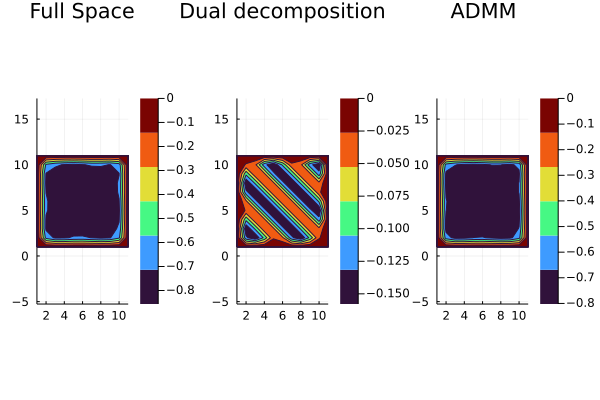

In [29]:
using Plots
l = @layout [a b c]
p1 = contourf(1:n+1, 1:n+1, admm_final_state, color = :turbo, levels = 5, 
aspect_ratio=:equal, title = "ADMM")
p2 = contourf(1:n+1, 1:n+1, dd_final_state, color = :turbo, levels = 5, 
aspect_ratio=:equal, title = "Dual decomposition")
p3 = contourf(1:n+1, 1:n+1, fs_final_state, color = :turbo, levels = 5, 
aspect_ratio=:equal, title = "Full Space")
plot(p3, p2, p1, layout = l)

In [32]:
savefig("control_inputs_comparison.png")